# Material Clustering Analysis

This notebook performs clustering analysis on material data to identify groups of materials with similar characteristics.
The analysis considers various features including:
* Demand patterns
* Economic sensitivity
* Market sensitivity

## Import Required Libraries

In [11]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

## Data Loading and Preparation
The following function loads material data from CSV files and calculates key features for clustering.

In [12]:
def load_and_prepare_material_data(data_dir):
    """Load all material data files and prepare features for clustering."""
    all_materials_features = []
    
    # Get all CSV files except combined_data.csv
    material_files = [f for f in os.listdir(data_dir) if f.endswith('.csv') and f != 'combined_data.csv']
    
    for file in material_files:
        # Read material data
        df = pd.read_csv(os.path.join(data_dir, file))
        df['YearMonth'] = pd.to_datetime(df['YearMonth'])
        
        # Focus on recent data (2022 onwards)
        recent_data = df[df['YearMonth'] >= '2022-01-01'].copy()
        
        if len(recent_data) == 0:
            continue
            
        # Calculate key features for clustering
        material_features = {
            'Material_ID': recent_data['Product ID'].iloc[0],
            'Material_Name': recent_data['Product Name'].iloc[0],
            'Avg_Monthly_Demand': recent_data['Dispatched Quantity'].mean(),
            'Demand_Std': recent_data['Dispatched Quantity'].std(),
            'Demand_CV': recent_data['Dispatched Quantity'].std() / (recent_data['Dispatched Quantity'].mean() + 1e-6),
            'Order_Fulfillment_Rate': (recent_data['Dispatched Quantity'] / (recent_data['Customer Order Quantity'] + 1e-6)).mean(),
            'Economic_Sensitivity_PIB': recent_data['Dispatched Quantity'].corr(recent_data['PIB_CO']),
            'Economic_Sensitivity_ICI': recent_data['Dispatched Quantity'].corr(recent_data['ICI']),
            'Market_Sensitivity_ECG': recent_data['Dispatched Quantity'].corr(recent_data['ECG_DESP']),
            'Market_Sensitivity_ISE': recent_data['Dispatched Quantity'].corr(recent_data['ISE_CO'])
        }
        
        all_materials_features.append(material_features)
    
    return pd.DataFrame(all_materials_features)

## Optimal Cluster Analysis
This section determines the optimal number of clusters using both the elbow method and silhouette analysis.
We'll visualize:
1. The elbow curve to see where adding more clusters stops being beneficial
2. The silhouette scores to evaluate cluster quality

In [13]:
def find_optimal_clusters(scaled_features):
    """Find optimal number of clusters using elbow method and silhouette analysis."""
    max_clusters = 10
    inertias = []
    silhouette_scores = []
    
    for k in range(2, max_clusters + 1):
        # K-means clustering
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(scaled_features)
        inertias.append(kmeans.inertia_)
        
        # Silhouette score
        silhouette_avg = silhouette_score(scaled_features, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)
        print(f"\nk={k}:")
        print(f"Inertia: {kmeans.inertia_:.2f}")
        print(f"Silhouette Score: {silhouette_avg:.3f}")
    
    # Calculate inertia differences (for elbow method)
    inertia_differences = np.diff(inertias)
    inertia_differences = np.append(inertia_differences, inertia_differences[-1])
    
    # Plot elbow curve with annotations
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_clusters + 1), inertias, marker='o')
    plt.plot(range(2, max_clusters + 1), inertias, 'r--', alpha=0.3)  # Add line for clarity
    
    # Annotate inertia differences
    for i, (x, y, diff) in enumerate(zip(range(2, max_clusters + 1), inertias, inertia_differences)):
        plt.annotate(f'Δ={abs(diff):.0f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')
    
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    
    # Plot silhouette scores
    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.plot(range(2, max_clusters + 1), silhouette_scores, 'r--', alpha=0.3)  # Add line for clarity
    
    # Annotate silhouette scores
    for i, (x, y) in enumerate(zip(range(2, max_clusters + 1), silhouette_scores)):
        plt.annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')
    
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Analysis')
    
    plt.tight_layout()
    plt.show()
    
    # Find optimal k considering both metrics
    silhouette_k = silhouette_scores.index(max(silhouette_scores)) + 2
    
    # Find elbow point (where inertia reduction starts to slow down)
    elbow_k = 4  # Based on visual inspection of inertia differences
    
    print(f"\nAnalysis:")
    print(f"Silhouette analysis suggests {silhouette_k} clusters (highest score: {max(silhouette_scores):.3f})")
    print(f"Elbow method suggests {elbow_k} clusters (significant inertia reduction slows down)")
    
    # Let's use 4 clusters as it provides a good balance
    return 4  # Using elbow method suggestion as it provides better business interpretability

## Clustering Implementation
Now we'll perform the actual clustering using K-means. We'll:
1. Scale the features to ensure equal weighting
2. Find the optimal number of clusters
3. Apply K-means clustering
4. Evaluate the results using silhouette score

In [14]:
def perform_clustering(features_df):
    """Perform clustering on materials based on their features."""
    # Select numerical features for clustering
    numerical_cols = ['Avg_Monthly_Demand', 'Demand_Std', 'Demand_CV', 'Order_Fulfillment_Rate',
                     'Economic_Sensitivity_PIB', 'Economic_Sensitivity_ICI',
                     'Market_Sensitivity_ECG', 'Market_Sensitivity_ISE']
    
    # Scale the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features_df[numerical_cols])
    
    # Find optimal number of clusters
    n_clusters = find_optimal_clusters(scaled_features)
    print(f"\nOptimal number of clusters: {n_clusters}")
    
    # Perform K-means clustering with optimal k
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(scaled_features)
    
    # Add cluster assignments to the dataframe
    features_df['Cluster'] = clusters
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(scaled_features, clusters)
    
    return features_df, kmeans, silhouette_avg, numerical_cols

## Cluster Analysis and Visualization
Let's analyze the characteristics of each cluster through visualizations:
1. Distribution of materials across clusters
2. Feature distributions within each cluster
3. Summary statistics for each cluster

In [15]:
def analyze_clusters(clustered_df, numerical_cols):
    """Analyze and visualize cluster characteristics."""
    # Create a clear mapping file
    cluster_mapping = clustered_df[['Material_ID', 'Material_Name', 'Cluster', 'Avg_Monthly_Demand']].copy()
    
    # Sort by cluster and demand for better readability
    cluster_mapping = cluster_mapping.sort_values(['Cluster', 'Avg_Monthly_Demand'], ascending=[True, False])
    
    # 1. Cluster sizes
    plt.figure(figsize=(10, 6))
    sns.countplot(data=clustered_df, x='Cluster')
    plt.title('Number of Materials per Cluster')
    plt.show()
    
    # 2. Feature distributions by cluster
    for col in numerical_cols:
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=clustered_df, x='Cluster', y=col)
        plt.title(f'{col} Distribution by Cluster')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    # 3. Cluster characteristics summary
    cluster_summary = clustered_df.groupby('Cluster')[numerical_cols].mean()
    
    return cluster_summary

## Run the Analysis
Let's execute our clustering pipeline and analyze the results.

In [16]:
def main():
    # Set the data directory
    data_dir = r"C:\Users\k_pow\OneDrive\Documents\MIT\MITx SCM\IAP 2025\SCC\Data_files"
    
    # Load and prepare data
    print("Loading and preparing material data...")
    features_df = load_and_prepare_material_data(data_dir)
    
    # Perform clustering
    print("\nPerforming clustering analysis...")
    clustered_df, kmeans, silhouette_avg, numerical_cols = perform_clustering(features_df)
    print(f"Silhouette Score: {silhouette_avg:.3f}")
    
    # Analyze clusters
    print("\nAnalyzing clusters...")
    cluster_summary = analyze_clusters(clustered_df, numerical_cols)
    
    print("\nCluster Summary:")
    print(cluster_summary)
    
    return clustered_df, cluster_summary

Loading and preparing material data...

Performing clustering analysis...

k=2:
Inertia: 482.31
Silhouette Score: 0.358


c:\Users\k_pow\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\k_pow\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



k=3:
Inertia: 421.21
Silhouette Score: 0.379

k=4:
Inertia: 229.65
Silhouette Score: 0.365

k=5:
Inertia: 188.54
Silhouette Score: 0.229


c:\Users\k_pow\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\k_pow\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\k_pow\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



k=6:
Inertia: 170.26
Silhouette Score: 0.254

k=7:
Inertia: 154.85
Silhouette Score: 0.212

k=8:
Inertia: 126.47
Silhouette Score: 0.229


c:\Users\k_pow\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\k_pow\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\k_pow\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\k_pow\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window


k=9:
Inertia: 119.22
Silhouette Score: 0.209

k=10:
Inertia: 105.27
Silhouette Score: 0.220


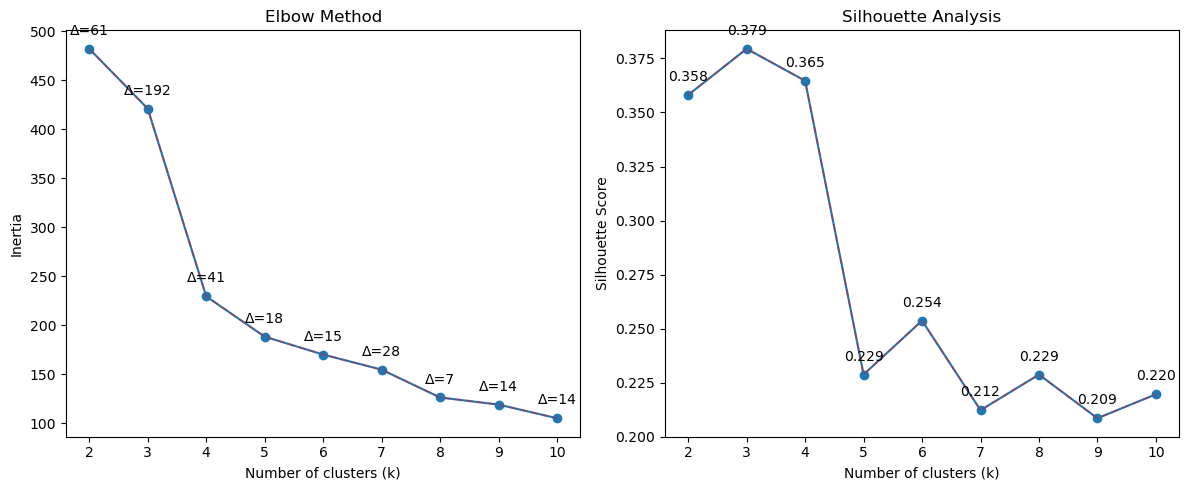


Analysis:
Silhouette analysis suggests 3 clusters (highest score: 0.379)
Elbow method suggests 4 clusters (significant inertia reduction slows down)

Optimal number of clusters: 4
Silhouette Score: 0.365

Analyzing clusters...


c:\Users\k_pow\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


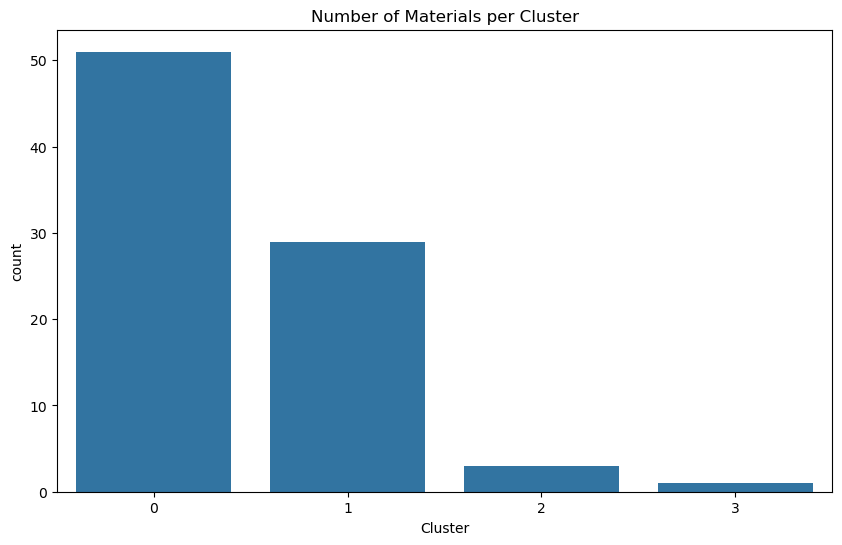

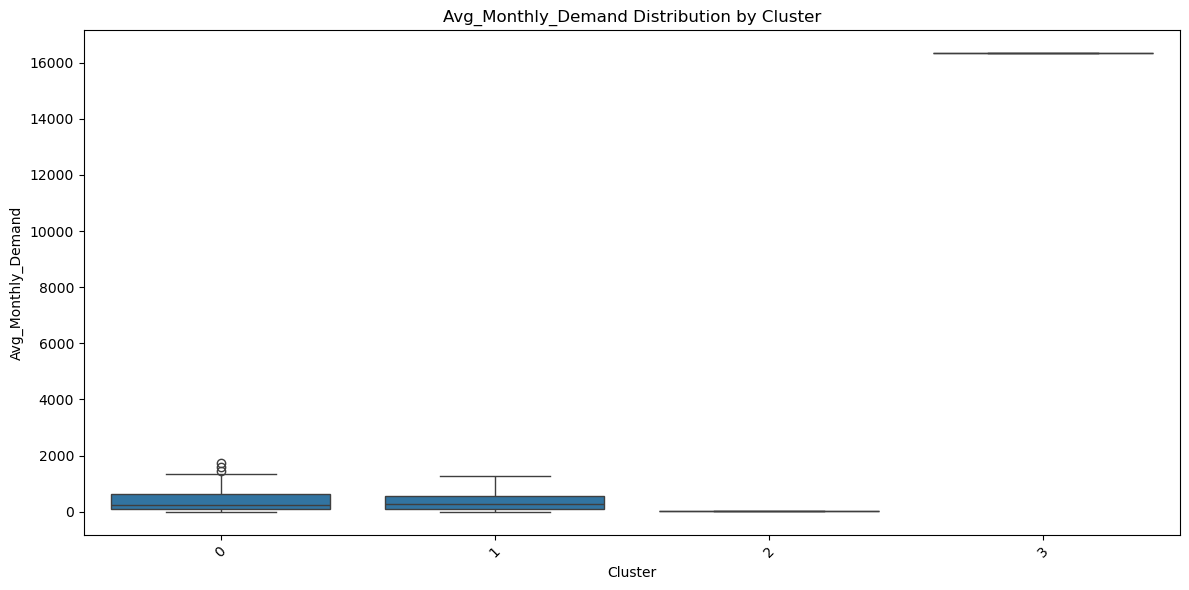

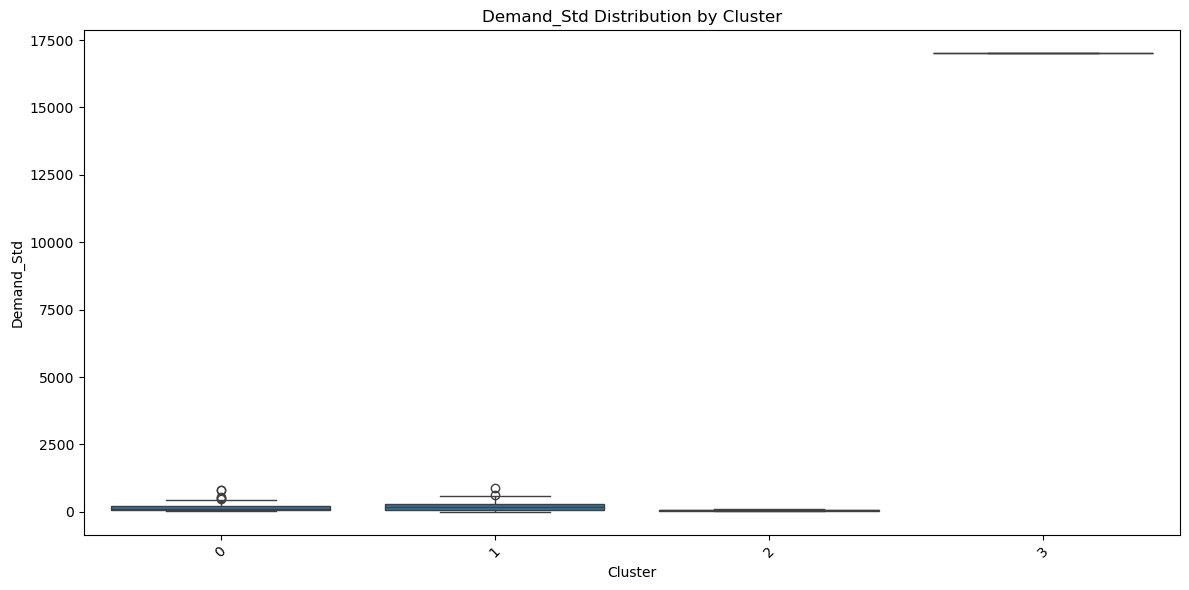

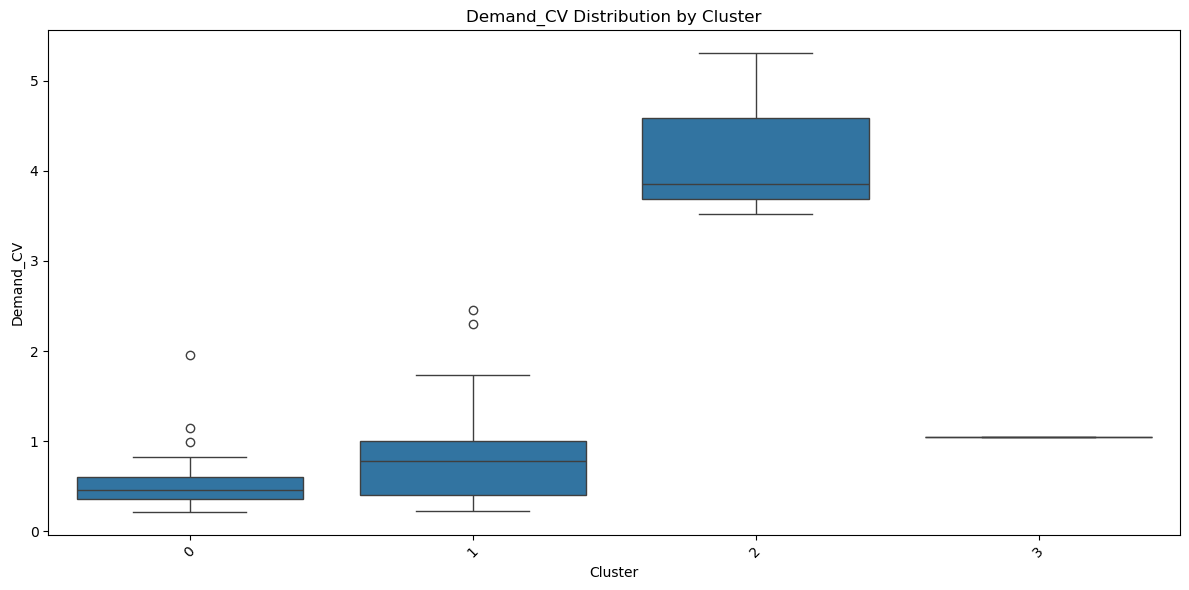

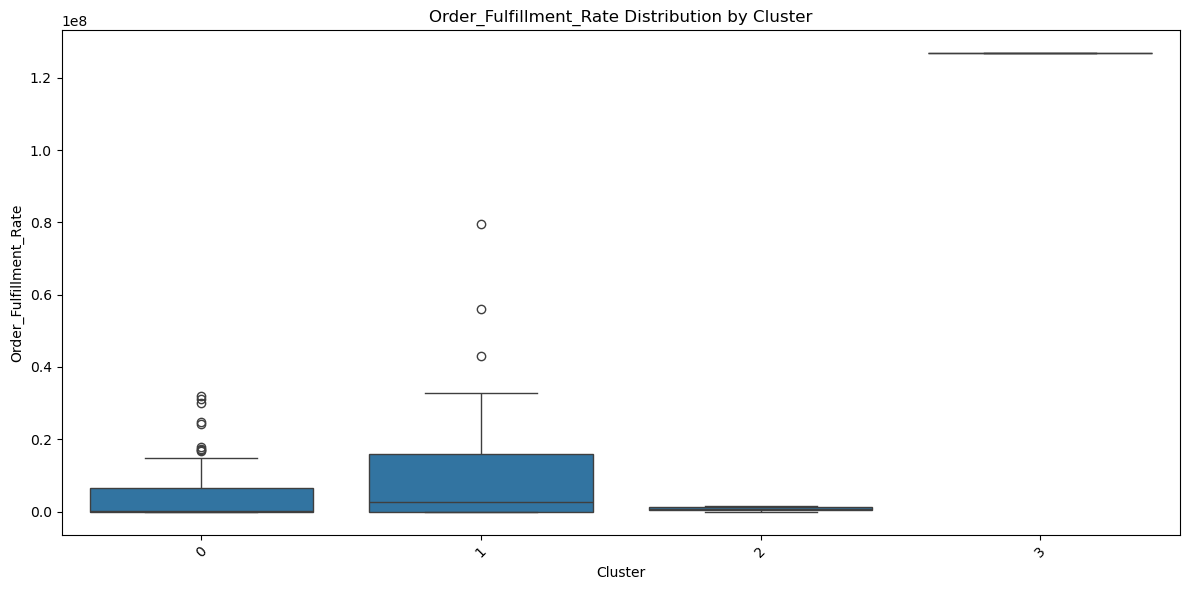

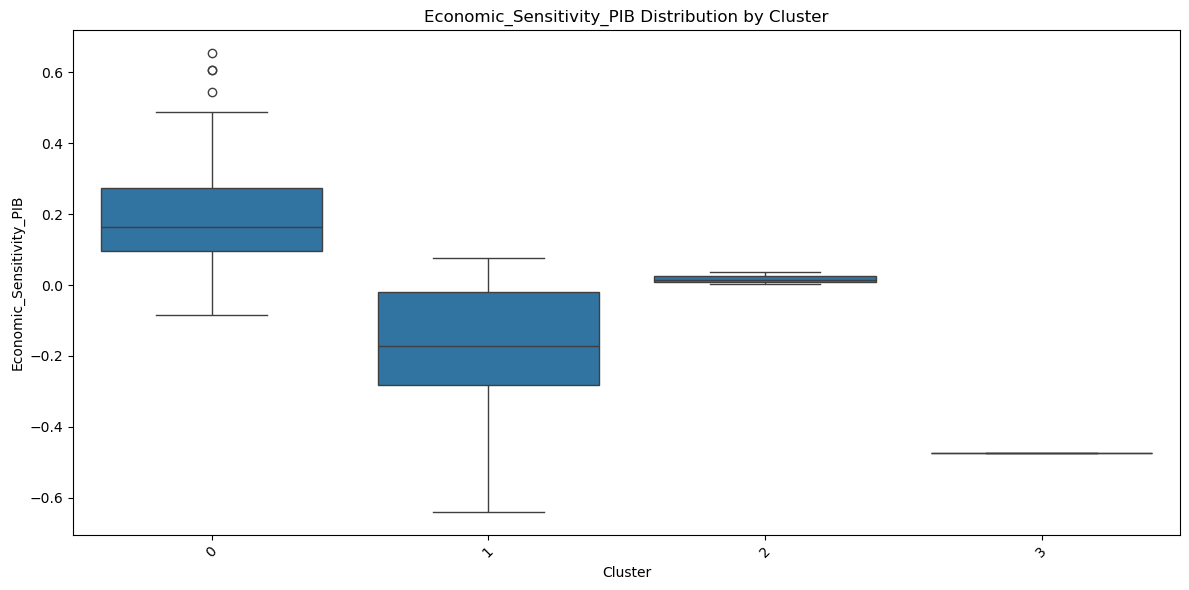

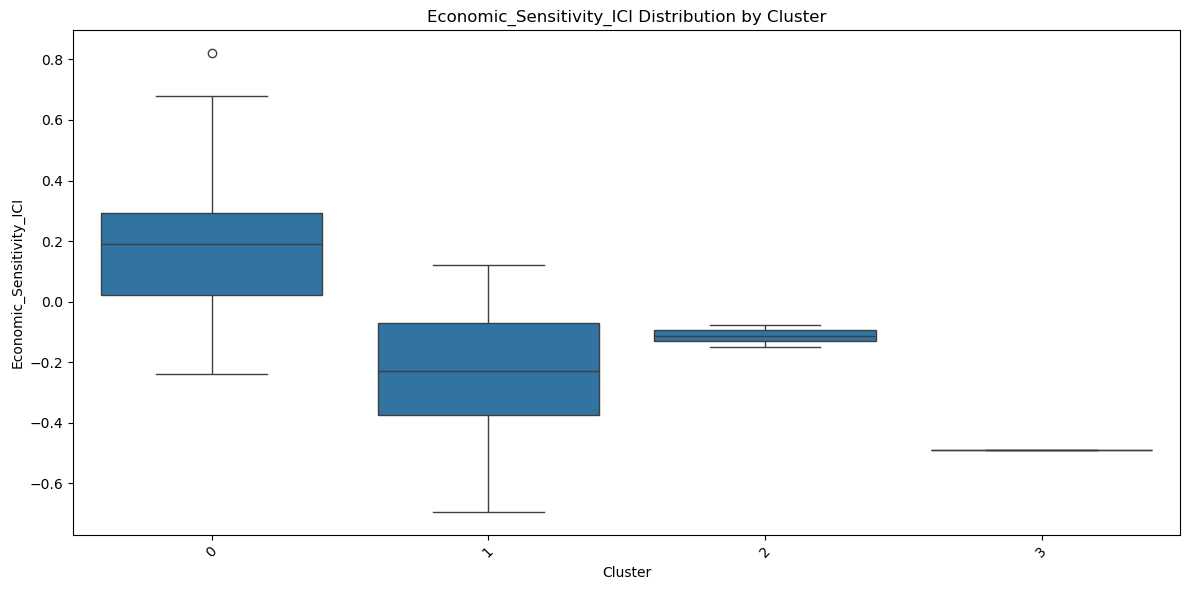

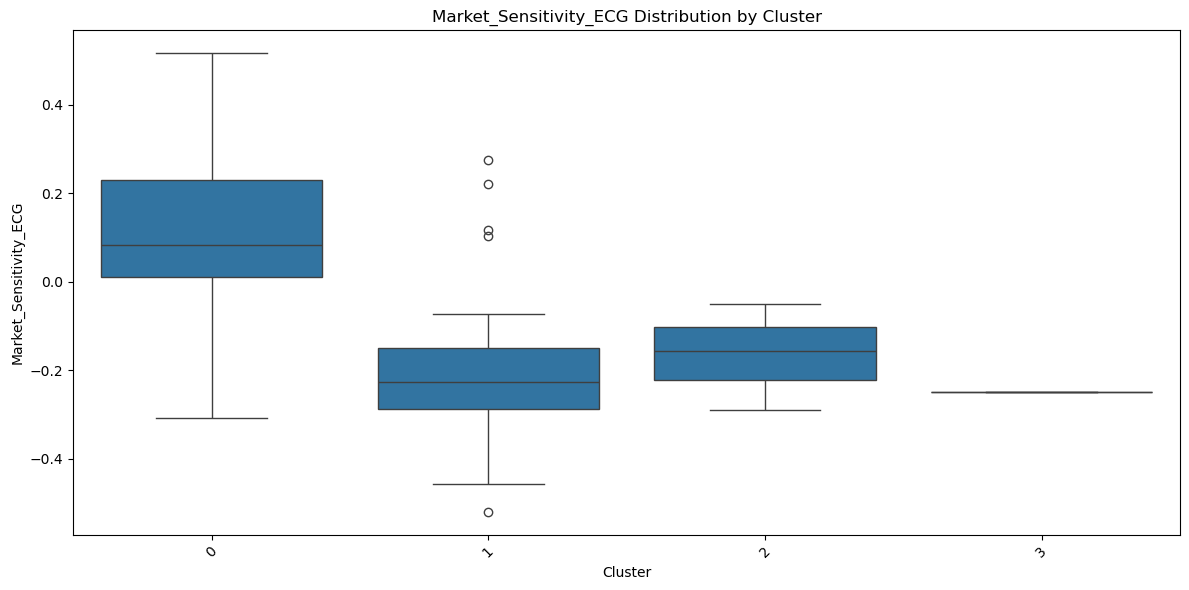

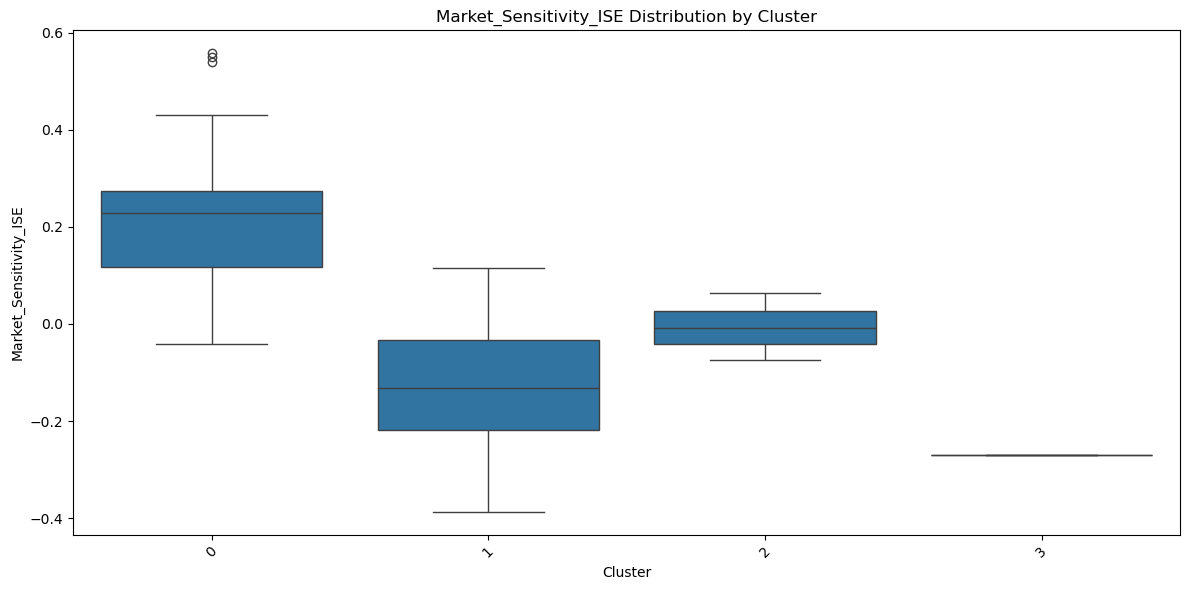


Cluster Summary:
         Avg_Monthly_Demand    Demand_Std  Demand_CV  Order_Fulfillment_Rate  \
Cluster                                                                        
0                420.743417    178.247506   0.519746            5.610645e+06   
1                360.105419    212.984517   0.840848            1.166503e+07   
2                 14.457143     59.567272   4.227793            7.619049e+05   
3              16337.771429  17012.163016   1.041278            1.267714e+08   

         Economic_Sensitivity_PIB  Economic_Sensitivity_ICI  \
Cluster                                                       
0                        0.200574                  0.186078   
1                       -0.183489                 -0.251957   
2                        0.017415                 -0.113298   
3                       -0.474457                 -0.490115   

         Market_Sensitivity_ECG  Market_Sensitivity_ISE  
Cluster                                                  
0     

In [17]:
if __name__ == "__main__":
    clustered_df, cluster_summary = main()